May 9: Results of the original GYRE configuration, new gyre configuration **attempt1**, and instructions and log of progress.

The new gyre configuration **attempt1** uses the rectangular bathymetry created below. The results in **Test_A** reflect only the addition of bathy_meter.nc to the original GYRE configuration. **Test_B** follows with a change from 100 to 50 for nn_tau000 in namsbc_ana.

In [3]:
import netCDF4 as nc
import numpy as np
from netCDF4 import Dataset
import time
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
%matplotlib inline

### GYRE Information

In [4]:
testT = nc.Dataset('/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/GYRE_Test/EXP00/GYRE_5d_00010101_00011230_grid_T.nc')
testU = nc.Dataset('/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/GYRE_Test/EXP00/GYRE_5d_00010101_00011230_grid_U.nc')
testV = nc.Dataset('/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/GYRE_Test/EXP00/GYRE_5d_00010101_00011230_grid_V.nc')
testW = nc.Dataset('/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/GYRE_Test/EXP00/GYRE_5d_00010101_00011230_grid_W.nc')
mmask = nc.Dataset('/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/GYRE_Test/EXP00/mesh_mask.nc')

In [5]:
mmask

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT data model, file format NETCDF3):
    DOMAIN_number_total: 1
    DOMAIN_number: 0
    DOMAIN_dimensions_ids: [1 2]
    DOMAIN_size_global: [32 22]
    DOMAIN_size_local: [32 22]
    DOMAIN_position_first: [1 1]
    DOMAIN_position_last: [32 22]
    DOMAIN_halo_size_start: [0 0]
    DOMAIN_halo_size_end: [0 0]
    DOMAIN_type: BOX
    dimensions(sizes): x(32), y(22), z(31), t(1)
    variables(dimensions): float32 nav_lon(y,x), float32 nav_lat(y,x), float32 nav_lev(z), float64 time_counter(t), int8 tmask(t,z,y,x), int8 umask(t,z,y,x), int8 vmask(t,z,y,x), int8 fmask(t,z,y,x), int8 tmaskutil(t,y,x), int8 umaskutil(t,y,x), int8 vmaskutil(t,y,x), int8 fmaskutil(t,y,x), float32 glamt(t,y,x), float32 glamu(t,y,x), float32 glamv(t,y,x), float32 glamf(t,y,x), float32 gphit(t,y,x), float32 gphiu(t,y,x), float32 gphiv(t,y,x), float32 gphif(t,y,x), float64 e1t(t,y,x), float64 e1u(t,y,x), float64 e1v(t,y,x), float64 e1f(t,y,x), float64 e2

In [6]:
lt = mmask.variables['glamt']
lu = mmask.variables['glamu']
lv = mmask.variables['glamv']
lf = mmask.variables['glamf']

pt = mmask.variables['gphit']
pu = mmask.variables['gphiu']
pv = mmask.variables['gphiv']
pf = mmask.variables['gphif']

t1 = mmask.variables['e1t']
u1 = mmask.variables['e1u']
v1 = mmask.variables['e1v']
f1 = mmask.variables['e1f']

t2 = mmask.variables['e2t']
u2 = mmask.variables['e2u']
v2 = mmask.variables['e2v']
f2 = mmask.variables['e2f']

GYRE structure (t, z, y, x) = (72, 31, 22, 32)

In [7]:
tem = testT.variables['votemper']
sal = testT.variables['vosaline']
ssh = testT.variables['sossheig']
U = testU.variables['vozocrtx']
V = testV.variables['vomecrty']
W = testW.variables['vovecrtz']
lon = mmask.variables['nav_lon']
lat = mmask.variables['nav_lat']
dep = testT.variables['deptht']

### GYRE Results

The bathymetry used in the gyre run is rectangular with a 1-cell coastline going around the four sides. The rest of the bathymetry is flat at 30 m depth.

Animation showing the results of the gyre run used to test NEMO's configuration settings

In [8]:
def draw_diff(fig, t, axes, varb, ttls, lon, lat, dep_ind):
    cmap0 = cm.RdYlBu_r
    for ax, var, ttl in zip(axes, varb, ttls):
        if ax == ax_ssh:
            end_point = max(abs(var[t, 1:21,1:31].max()), abs(var[t, 1:21,1:31].min()))
            cmax = end_point
            cmin = -1*end_point
            c = ax.pcolormesh(lon, lat, var[t,:,:], cmap=cmap0, vmin=cmin, vmax=cmax)
            fig.colorbar(c, ax=ax)
        else:
            end_point = max(abs(var[t,dep_ind, 1:21,1:31].max()), abs(var[t,dep_ind, 1:21,1:31].min()))
            cmax = end_point
            cmin = -1*end_point
            c = ax.pcolormesh(lon, lat, var[t,dep_ind,:,:], cmap=cmap0, vmin=cmin, vmax=cmax)
            fig.colorbar(c, ax=ax)
        ax.set_title(ttl)
        ax.set_ylabel('latitude')
        ax.set_xlabel('longitude')
    return fig

In [9]:
def animate_gyre(fig, axes, varb, ttls, dep_ind, frames, file_name):
    
    def init():
        pass

    def animate(t):
        draw(t, axes, varb, ttls, lon, lat, dep_ind)

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=frames, interval=20, blit=False, repeat=False)
    mywriter = animation.FFMpegWriter()
    anim.save(file_name, writer=mywriter, fps=1, dpi=200, bitrate=1000000, codec="libx264")

### Test Bathymetry

Replace the flat bathymetry used in GYRE with the simple bathymetry below.

In [10]:
x = np.linspace(0,3,32)
y = np.linspace(0,2,22)
z = np.ones((len(y),len(x)))* 1000
for indx in np.arange(10,25):
    for indy in np.arange(5,15):
        z[indy, indx] = 2300
z[-1,:] = 0

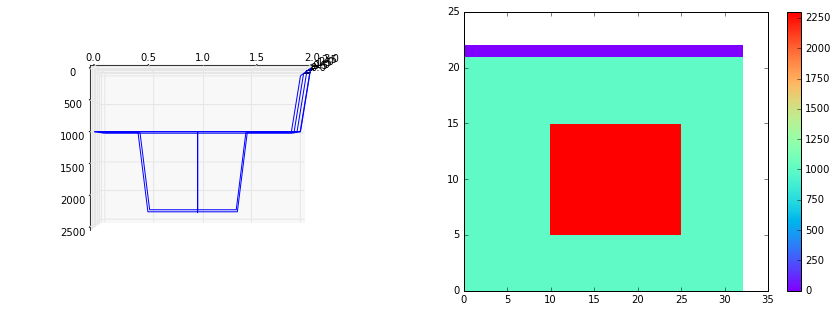

In [11]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
X, Y = np.meshgrid(x, y)
ax.plot_wireframe(X, Y, z, rstride=10, cstride=10)
ax.view_init(elev=0, azim=0)
ax.invert_zaxis()

ax = fig.add_subplot(1, 2, 2)
p = ax.pcolor(z, cmap=cm.rainbow)
fig.colorbar(p)

bathy files have **variables (dimensions)**: float64 nav_lon(y,x), float64 nav_lat(y,x), float64 Bathymetry(y,x)

http://unidata.github.io/netcdf4-python/

http://www.ceda.ac.uk/static/media/uploads/ncas-reading-2015/11_create_netcdf_python.pdf

The new bathymetry is inputted into gyre in NETCDF4 format. The file has the longitudes and latitudes originally used in gyre. The new bathymetry has the same size as the original, but it has a different depth profile.

In [12]:
bathy_rectangle = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/notebooks/bathy_rectangle.nc')

In [13]:
bathy_rectangle

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: Rectangular Bathymetry for Gyre Test Run
    author: Idalia A. Machuca
    institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
    source: bitbucket.org/CanyonsUBC/mackenzie_canyon/raw/tip/bathymetry/notebooks/gyre_test.ipynb
    timeStamp: Wed May 25 21:54:12 2016
    dimensions(sizes): y(22), x(32)
    variables(dimensions): float64 nav_lon(y,x), float64 nav_lat(y,x), float64 Bathymetry(y,x)
    groups: 

In [14]:
bathy_rectangle.variables

OrderedDict([('nav_lon', <class 'netCDF4._netCDF4.Variable'>
              float64 nav_lon(y, x)
                  standard_name: longitude
                  units: degrees_east
              unlimited dimensions: 
              current shape = (22, 32)
              filling on, default _FillValue of 9.969209968386869e+36 used),
             ('nav_lat', <class 'netCDF4._netCDF4.Variable'>
              float64 nav_lat(y, x)
                  standard_name: latitude
                  units: degrees_north
              unlimited dimensions: 
              current shape = (22, 32)
              filling on, default _FillValue of 9.969209968386869e+36 used),
             ('Bathymetry', <class 'netCDF4._netCDF4.Variable'>
              float64 Bathymetry(y, x)
                  standard_name: bathymetry
                  units: m
                  positive: down
              unlimited dimensions: 
              current shape = (22, 32)
              filling on, default _FillValue of 9.96920

In [15]:
bat_test = bathy_rectangle.variables['Bathymetry']
(bat_test[:]-z[:]).max()

0.0

### Test Coordinates

* float32 nav_lon(y,x), float32 nav_lat(y,x)

float32 time(time), int32 time_steps(time)

* float64 glamt(time,y,x), float64 glamu(time,y,x), float64 glamv(time,y,x), float64 glamf(time,y,x)

* float64 gphit(time,y,x), float64 gphiu(time,y,x), float64 gphiv(time,y,x), float64 gphif(time,y,x)

* float64 e1t(time,y,x), float64 e1u(time,y,x), float64 e1v(time,y,x), float64 e1f(time,y,x)

* float64 e2t(time,y,x), float64 e2u(time,y,x), float64 e2v(time,y,x), float64 e2f(time,y,x)

In [16]:
coords_rectangle = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/notebooks/coords_rectangle.nc')

In [17]:
coords_rectangle

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: Rectangular Coordinates for Gyre Test Run
    author: Idalia A. Machuca
    institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
    source: bitbucket.org/CanyonsUBC/mackenzie_canyon/raw/tip/bathymetry/notebooks/gyre_test.ipynb
    dimensions(sizes): y(22), x(32), time(1)
    variables(dimensions): float32 nav_lon(y,x), float32 nav_lat(y,x), float64 glamt(time,y,x), float64 glamu(time,y,x), float64 glamv(time,y,x), float64 glamf(time,y,x), float64 gphit(time,y,x), float64 gphiu(time,y,x), float64 gphiv(time,y,x), float64 gphif(time,y,x), float64 e1t(time,y,x), float64 e1u(time,y,x), float64 e1v(time,y,x), float64 e1f(time,y,x), float64 e2t(time,y,x), float64 e2u(time,y,x), float64 e2v(time,y,x), float64 e2f(time,y,x)
    groups: 

In [18]:
coords_rectangle.variables['e2f'][0,0,0] - f2[0,0,0]

0.0

### Running New Configuration

Log in to Salish!

**Original: GYRE**

**New: attempt1**

The code for the gyre run is in /ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/GYRE/EXP00/. 

**Make a new NEMO configuration**
* Go to /ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/
* ./makenemo -r GYRE -n attempt1

This builds a new nemo configuration called attempt1 that is exactly the same as GYRE. "makenemo" is a file that is in CONFIG.

**Run the new configuration**
* cd attempt1/EXP00
* nice ./opa &

This command runs the nemo model - the new configuation attempt1. "opa" is a file in EXP00, which was generated when the configuration was built. The ampersand runs nemo in the background so you can keep using the terminal.


**Make changes to the new configuration**
* Change EXP00/**namelist_cfg** >>> **namdom** >> **nn_bathy** to 1
* In EXP00: ln -s /ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/notebooks/bathy_rectangle.nc **bathy_meter.nc**
* In CONFIG: ./makenemo -n attempt1

We use "namelist_cfg" because "namelist_ref" is a symbolic link, so it was probably not being used. The building command is shorter because attempt1 is using itself as a reference since changes have been made to it. Get used to building new configurations until you get used to nemo.

**Run the newer configuration**

**Other notes:**
* tail cfg.txt -------------------------------------- list of nemo configurations
* make changes to files in WORK
* tail time.step --------------------------------- tracks run time
* kill 8282 --------------------------------------- stops nemo when job number is 8282
* tail ocean.output ---------------------------- track model run errors
* emacs iodef.xml ---------------------------- make changes to frequency of model results
* Deleting a previously built configuration and attempting to rebuild it doesn't work.
* If a configuration is already built, it doesn't re-run (with "nice) if it has a bathymetry, but it can still re-run without it ---- solution below.
* The new configuration was initially built as Gyre0.
* ./makenemo -r attemp1 -n attempt2 works but remember to go on Salish
* re-building attempt1 as GYRE didn't overwrite the Test_A folder or switch nnbathy to 0.

**Finding out what was wrong with attempt1:**
* **nice ./opa &** runs nemo (didn't have to rebuild here)
* **tail ocean.output** at the bottom of this file is the number of errors that have occurred. Scan through the entire file to find **E R R O R**. In this case, there was one error that said that the file **bathy_level.nc** didn't exist. **bathy_level.nc** is not the same as **bathy_meter.nc**.
* **WORK/** is where the nemo code is stored. Don't change anything in here because it will affect the Salish Sea group if the changes are pushed.
* **grep 'bathy_level' *.F90** finds the words bathy_level in all files that contain .F90. This should tell us what bathy_level is because it's not in the manual. The result of the search is
        domzgr.F90:      !!      ntopo= 1 :   mbathy is read in 'bathy_level.nc' NetCDF file
* In routine **zgr_bat** of **domzgr.F90**, the following description is given for topography:

        ntopo=-1 :   rectangular channel or bassin with a bump 

        ntopo= 0 :   flat rectangular channel or basin 

        ntopo= 1 :   mbathy is read in 'bathy_level.nc' NetCDF file

                     bathy  is read in 'bathy_meter.nc' NetCDF file

* Further down in the routine, the code defines two conditions when **ntopo=1**:

        IF( ln_zco )   THEN                          ! zco : read level bathymetry 
                    CALL iom_open ( 'bathy_level.nc', inum )

        IF( ln_zps .OR. ln_sco )   THEN              ! zps or sco : read meter bathymetry
                    CALL iom_open ( 'bathy_meter.nc', inum )

* In **namlist_cfg** there is a section **namzgr** that defines details about the vertical coordinates, in particular **ln_zco** and **ln_zps**. I specified the following:

       ln_zco      = .false.    !  z-coordinate - full    steps   (T/F)      ("key_zco" may also be defined)
       ln_zps      = .true.   !  z-coordinate - partial steps   (T/F)

    Originally, the true and false were the other way around, but we want to use partial steps so that nemo looks for **bathy_meter.nc**. According to the nemo manual (pg. 58), there shoudl be another option **ln_sco** for an s-coordinate, but that was not included in the namelist I'm using.


* Note: In **attempt1/cpp_attempt1.fcm**, there is a list of keys that are used to unlock modules in nemo. Since no key was specified for **ln_zps**, we don't need to add any to the file.

* Run nemo and check in **ocean.ouput** if it ran properly:

        iom_nf90_rp0123d, file: ./GYRE_00004320_restart.nc, var: sshn written ok
        iom_nf90_rp0123d, file: ./GYRE_00004320_restart.nc, var: rhop written ok
        iom_close ~~~ close file: ./GYRE_00004320_restart.nc ok


**Questions**
* Do I need coordinates.nc if i'm using partial steps?
* If you use **ln_zco**, you need to define a reference coordinate transformation $z_o(k)$, which is an analytical expression of depth, and its first derivative with respect to k. This is done in **domzgr.F90**.

### attempt1/Test_A Results

In [19]:
attT = nc.Dataset('/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/attempt1/EXP00/Test_A/GYRE_5d_00010101_00011230_grid_T.nc')
attU = nc.Dataset('/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/attempt1/EXP00/Test_A/GYRE_5d_00010101_00011230_grid_U.nc')
attV = nc.Dataset('/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/attempt1/EXP00/Test_A/GYRE_5d_00010101_00011230_grid_V.nc')
attW = nc.Dataset('/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/attempt1/EXP00/Test_A/GYRE_5d_00010101_00011230_grid_W.nc')
attmask = nc.Dataset('/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/attempt1/EXP00/Test_A/mesh_mask.nc')

In [20]:
# New variables!
attmask

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT data model, file format NETCDF3):
    DOMAIN_number_total: 1
    DOMAIN_number: 0
    DOMAIN_dimensions_ids: [1 2]
    DOMAIN_size_global: [32 22]
    DOMAIN_size_local: [32 22]
    DOMAIN_position_first: [1 1]
    DOMAIN_position_last: [32 22]
    DOMAIN_halo_size_start: [0 0]
    DOMAIN_halo_size_end: [0 0]
    DOMAIN_type: BOX
    dimensions(sizes): x(32), y(22), z(31), t(1)
    variables(dimensions): float32 nav_lon(y,x), float32 nav_lat(y,x), float32 nav_lev(z), float64 time_counter(t), int8 tmask(t,z,y,x), int8 umask(t,z,y,x), int8 vmask(t,z,y,x), int8 fmask(t,z,y,x), int8 tmaskutil(t,y,x), int8 umaskutil(t,y,x), int8 vmaskutil(t,y,x), int8 fmaskutil(t,y,x), float32 glamt(t,y,x), float32 glamu(t,y,x), float32 glamv(t,y,x), float32 glamf(t,y,x), float32 gphit(t,y,x), float32 gphiu(t,y,x), float32 gphiv(t,y,x), float32 gphif(t,y,x), float64 e1t(t,y,x), float64 e1u(t,y,x), float64 e1v(t,y,x), float64 e1f(t,y,x), float64 e2

In [21]:
attT

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    name: GYRE_5d_00010101_00011230
    description: ocean T grid variables
    title: ocean T grid variables
    Conventions: CF-1.5
    production: An IPSL model
    timeStamp: 2016-May-26 12:58:02 PDT
    dimensions(sizes): axis_nbounds(2), x(32), y(22), deptht(31), time_counter(72)
    variables(dimensions): float32 nav_lat(y,x), float32 nav_lon(y,x), float32 deptht(deptht), float32 deptht_bounds(deptht,axis_nbounds), float32 votemper(time_counter,deptht,y,x), float64 time_centered(time_counter), float64 time_centered_bounds(time_counter,axis_nbounds), float64 time_counter(time_counter), float64 time_counter_bounds(time_counter,axis_nbounds), float32 vosaline(time_counter,deptht,y,x), float32 sosstsst(time_counter,y,x), float32 sosaline(time_counter,y,x), float32 sossheig(time_counter,y,x), float32 sowaflup(time_counter,y,x), float32 soshfldo(time_counter,y,x), float32 sosfldow(time_counter,y,x), 

In [22]:
tem_att = attT.variables['votemper']
sal_att = attT.variables['vosaline']
ssh_att = attT.variables['sossheig']
U_att = attU.variables['vozocrtx']
V_att = attV.variables['vomecrty']
W_att = attW.variables['vovecrtz']
lon_att = attmask.variables['nav_lon']
lat_att = attmask.variables['nav_lat']
mbathy_att = attmask.variables['mbathy']
tbathy_att = attT.variables['deptht']

In [23]:
d_tem = np.subtract(tem_att,tem)
d_sal = np.subtract(sal_att,sal)
d_ssh = np.subtract(ssh_att,ssh)
d_U = np.subtract(np.abs(U_att),np.abs(U))
d_V = np.subtract(np.abs(V_att),np.abs(V))
d_W = np.subtract(np.abs(W_att),np.abs(W))

In [24]:
d_sal.shape

(72, 31, 22, 32)

In [25]:
test = np.zeros_like(d_sal)
test.shape

(72, 31, 22, 32)

**Summary**: This configuration uses bathy_meter.nc alone and partial steps.

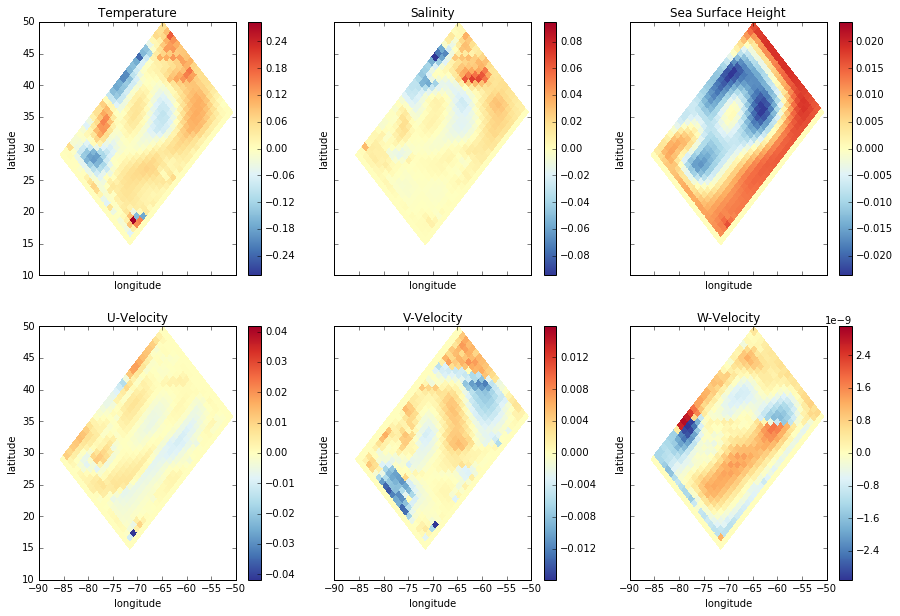

In [26]:
fig, [(ax1, ax2, ax_ssh),(ax_u, ax_v, ax_w)] = plt.subplots(2,3,figsize=(15,10),sharex=True, sharey=True)
axes = [ax1, ax2, ax_ssh, ax_u, ax_v, ax_w]
varb = [d_tem, d_sal, d_ssh, d_U, d_V, d_W]
ttls = ['Temperature', 'Salinity', 'Sea Surface Height', 'U-Velocity', 'V-Velocity', 'W-Velocity']
dep_ind = 0
t = 47

fig = draw_diff(fig, t, axes, varb, ttls, lon, lat, dep_ind)

#for ax, n in zip(axes, np.arange(len(axes))):
#    ax.pcolor(lon, lat, mbathy_att[0,:,:], cmap=cm.PRGn_r, alpha=0.2)

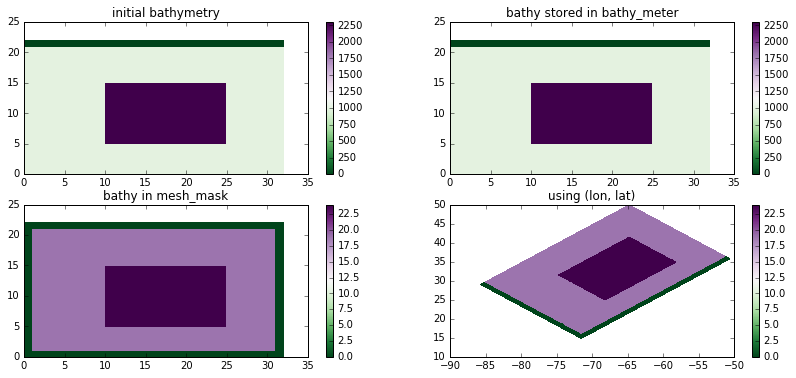

In [27]:
fig, [(ax1, ax2), (ax3, ax4)] = plt.subplots(2,2,figsize=(14,6))

axes = [ax1, ax2, ax3, ax4]
plot_values = [z[:], bat_test[:], mbathy_att[0,:,:], mbathy_att[0,:,:]]
ttls = ['initial bathymetry', 'bathy stored in bathy_meter', 'bathy in mesh_mask', 'using (lon, lat)']

for axs, pv, ttl in zip(axes, plot_values, ttls):
    if axs == ax4:
        axs.pcolor(lon, lat, mbathy_att[0,:,:], cmap=cm.PRGn_r)
    else:
        p = axs.pcolor(pv, cmap=cm.PRGn_r)
    fig.colorbar(p, ax=axs)
    axs.set_title(ttl)

(coast, flat plain, rectangular hole)
* ** bathy_meter.nc (z, bat_test)**: 0, 1000, 2300 (one wall)
* ** mesh_mask.nc (mbathy)**: 0, 19, 24 (four walls)
* ** grid_t.nc (deptht)**: grid depths (from 4.9 m to 4451 m )

**Changing wind forcing for later**
* namelist_cfg has a surface section, but it says that it uses a constant forcing so it's probably getting it from somewhere else
* look into WORK/par_oce but there should be a par_gyre
* copy par_oce into MY_SRC
* It'll use WORK and MY_SRC
* Don't change anything in WORK or NEMOGCM/NEMO
* More surface code /NEMOGCM/NEMO/OPA_SRC/SBC

### Looking at wind forcing
    !-----------------------------------------------------------------------                                        
    &namsbc        !   Surface Boundary Condition (surface module)                                                  
    !-----------------------------------------------------------------------                                        
       nn_fsbc     = 1         !  frequency of surface boundary condition computation                               
       !                       !     (also = the frequency of sea-ice model call)                                   
       ln_ana      = .true.    !  analytical formulation                    (T => fill namsbc_ana )                 
       ln_blk_core = .false.   !  CORE bulk formulation                     (T => fill namsbc_core)                 
       nn_ice      = 0         !  =0 no ice boundary condition   ,                                                  
       ln_rnf      = .false.   !  runoffs                                   (T => fill namsbc_rnf)                  
       ln_ssr      = .false.   !  Sea Surface Restoring on T and/or S       (T => fill namsbc_ssr)                  
       nn_fwb      = 0         !  FreshWater Budget: =0 unchecked                                                   
    /
    !-----------------------------------------------------------------------                                        
    &namsbc_ana    !   analytical surface boundary condition                                                        
    !-----------------------------------------------------------------------                                        
       nn_tau000   =   100     !  gently increase the stress over the first ntau_rst time-steps                     
       rn_utau0    =   0.1e0   !  uniform value for the i-stress 
       

**Test_B**: Changing ``nn_tau000`` from 100 to 50 didn't change the results. Maybe there is a difference somewhere around the ``ntau_rst``th time-step, but I didn't change that - but I also don't know where it's defined.

### attempt1/Test_B Results

In [28]:
attTB = nc.Dataset('/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/attempt1/EXP00/Test_B/GYRE_5d_00010101_00011230_grid_T.nc')
attUB = nc.Dataset('/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/attempt1/EXP00/Test_B/GYRE_5d_00010101_00011230_grid_U.nc')
attVB = nc.Dataset('/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/attempt1/EXP00/Test_B/GYRE_5d_00010101_00011230_grid_V.nc')
attWB = nc.Dataset('/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/attempt1/EXP00/Test_B/GYRE_5d_00010101_00011230_grid_W.nc')
attmaskB = nc.Dataset('/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/attempt1/EXP00/Test_B/mesh_mask.nc')

In [50]:
tem_attB = attTB.variables['votemper']
sal_attB = attTB.variables['vosaline']
ssh_attB = attTB.variables['sossheig']
U_attB = attUB.variables['vozocrtx']
V_attB = attVB.variables['vomecrty']
W_attB = attWB.variables['vovecrtz']
#
ref_varb0 = [tem, sal, ssh, U, V, W]
ref_varbA = [tem_att, sal_att, ssh_att, U_att, V_att, W_att]
ref_varb = ref_varbA
#
d_temB = np.subtract(tem_attB,ref_varb[0])
d_salB = np.subtract(sal_attB,ref_varb[1])
d_sshB = np.subtract(ssh_attB,ref_varb[2])
d_UB = np.subtract(np.abs(U_attB),np.abs(ref_varb[3]))
d_VB = np.subtract(np.abs(V_attB),np.abs(ref_varb[4]))
d_WB = np.subtract(np.abs(W_attB),np.abs(ref_varb[5]))

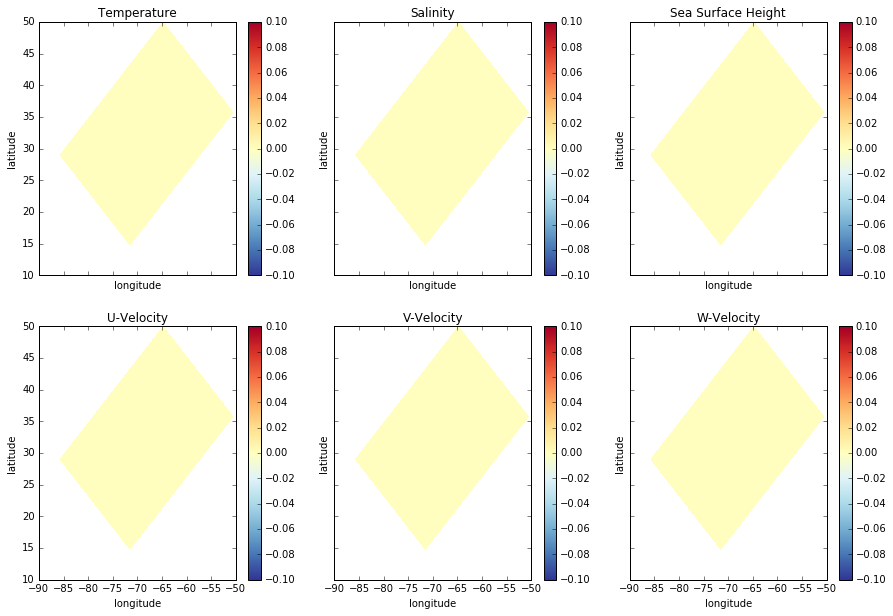

In [51]:
fig, [(ax1, ax2, ax_ssh),(ax_u, ax_v, ax_w)] = plt.subplots(2,3,figsize=(15,10),sharex=True, sharey=True)
axes = [ax1, ax2, ax_ssh, ax_u, ax_v, ax_w]
varb = [d_temB, d_salB, d_sshB, d_UB, d_VB, d_WB]
ttls = ['Temperature', 'Salinity', 'Sea Surface Height', 'U-Velocity', 'V-Velocity', 'W-Velocity']
dep_ind = 0
t = 47

fig = draw_diff(fig, t, axes, varb, ttls, lon, lat, dep_ind)